# Cross-match RACS-mid DR2 catalog with Gaia DR3

In this notebook, we will cross-match the RACS-mid DR2 catalog of radio-sources with the Gaia DR3 and Gaia EDR3 distance catalogs.
We will use the `hats-import` library to create a HATS catalog from the RACS-mid DR2 catalog, and then we will cross-match it with Gaia HATS catalogs using the `lsdb` library.

### Install and import the required libraries

In [2]:
from numba.cuda import threadfence
%pip install lsdb hats-import

In [33]:
import lsdb
from astropy.coordinates import Angle, SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
from dask.distributed import Client
from hats_import.catalog.arguments import ImportArguments
from hats_import.pipeline import pipeline_with_client
from matplotlib.colors import LogNorm

### Convert RACS-mid DR2 FITS file to HATS catalog

Please download "RACS-mid_time_domain_components.fits" file from [the CSIRO Data Access Portal](https://data.csiro.au/collection/csiro%3A60982v1) and put it to the same directory as this notebook.

Next we run `hats-import` to convert the FITS file to a HATS catalog.
We use Dask client to parallelize the conversion process, please refer to the [`hats-import`](https://hats-import.readthedocs.io/en/latest/) and [Dask documentation](https://docs.dask.org/en/latest/setup/single-distributed.html) for more information.

In [9]:
%%time

args = ImportArguments(
    sort_columns="Gaussian_ID",
    ra_column="RA",
    dec_column="Dec",
    input_file_list=["RACS-mid_time_domain_components.fits"],
    file_reader="fits",
    output_artifact_name="racs-mid-dr2",
    output_path="./hats",
)
with Client() as client:
    display(client)
    pipeline_with_client(args, client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61141,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:61153,Total threads: 3
Dashboard: http://127.0.0.1:61158/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:61144,


Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/12 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 15.8 s, sys: 1.03 s, total: 16.8 s
Wall time: 57.9 s


### Load catalog metadata and plan the cross-match

Next, we will load the RACS-mid DR2 and Gaia DR3 catalog metadata using the `lsdb` library.
Here, no data is loaded, only the metadata is read and the analysis plan is created.

We load the local RACS catalog we just created and the Gaia catalogs from https://data.lsdb.io (check more catalogs listed there!).
We also select only few columns to speed up the analysis. 

For cross-matching, we use the nearest neighbor search with a 6 arcsec radius.

In [2]:
racs = lsdb.read_hats(
    'hats/racs-mid-dr2',
    columns=['RA', 'Dec', 'Peak_flux'],
)
gaia = lsdb.read_hats(
    'https://data.lsdb.io/hats/gaia_dr3/gaia/',
    margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs/',
    columns=['ra', 'dec', 'source_id', 'parallax_over_error'],
)
gaia_distances = lsdb.read_hats(
    'https://data.lsdb.io/hats/gaia_dr3/gaia_edr3_distances/',
    margin_cache='https://data.lsdb.io/hats/gaia_dr3/gaia_edr3_distances_10arcs/',
)

catalog = racs.crossmatch(
    gaia,
    radius_arcsec=6,
    suffixes=('', '_gaia'),
).join(
    gaia_distances,
    left_on='source_id_gaia',
    right_on='source_id',
    suffixes=('', '_gaia_dist'),
)
catalog

,RA,Dec,Peak_flux,ra_gaia,dec_gaia,source_id_gaia,parallax_over_error_gaia,_dist_arcsec,source_id_gaia_dist,r_med_geo_gaia_dist,r_lo_geo_gaia_dist,r_hi_geo_gaia_dist,r_med_photogeo_gaia_dist,r_lo_photogeo_gaia_dist,r_hi_photogeo_gaia_dist,flag_gaia_dist,ra_gaia_dist,dec_gaia_dist,Norder_gaia_dist,Dir_gaia_dist,Npix_gaia_dist
npartitions=3751,,,,,,,,,,,,,,,,,,,,,
0,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow]
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454260914193170432,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458764513820540928,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Plot catalog healpix tiles

Here we plot the catalog healpix structure.
If tile is shown it will be computed, but it doesn't nessessary mean that it has cross-matched sources. 

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - racs-mid-dr2_x_gaia'}>)

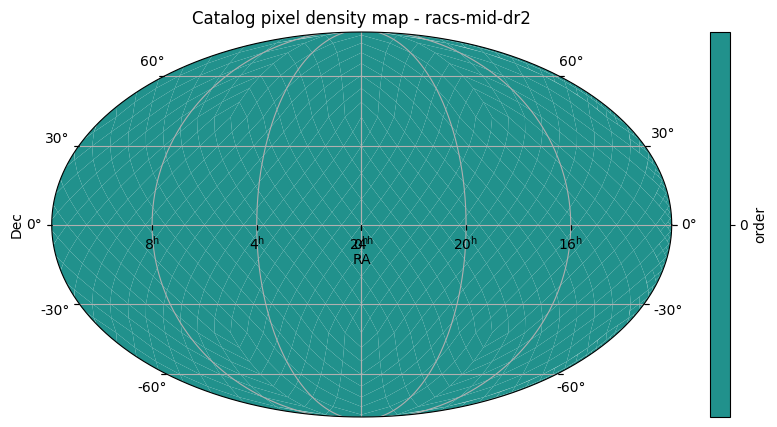

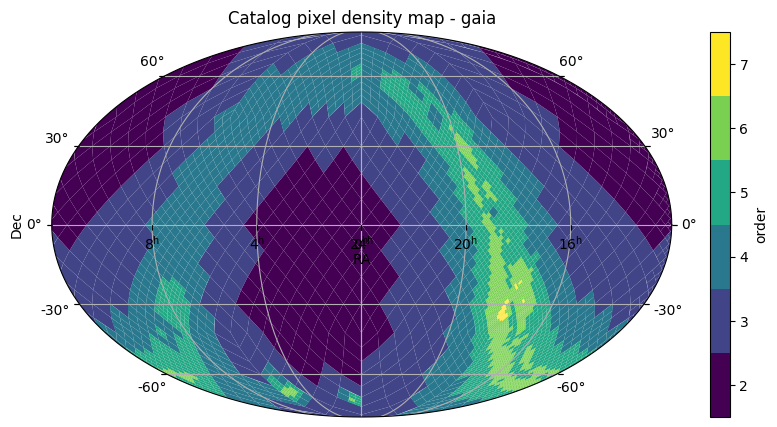

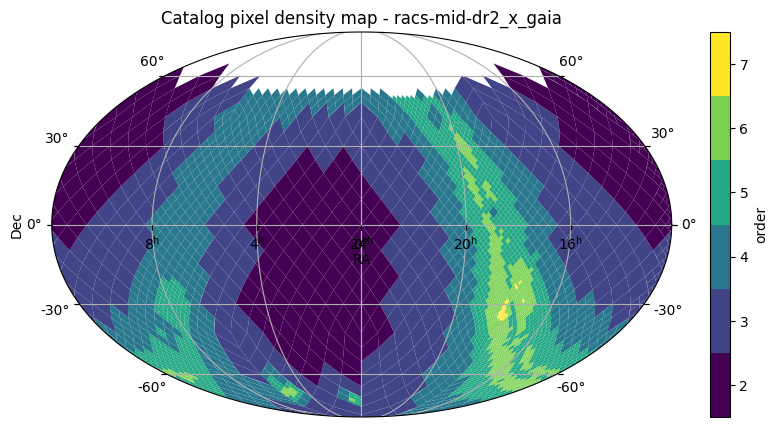

In [3]:
racs.plot_pixels()
gaia.plot_pixels()
catalog.plot_pixels()

### Run the cross=match and save the result to a HATS catalog

Finally, we run the cross-match using the Dask client to parallelize the process.
The result is saved to a HATS catalog.

Since Gaia catalog is pretty large and takes some time to download, we will select a cone on the sky to speed up the process.

In [4]:
%%time

# 2-degree cone around the RA=90, Dec=-45 point
cone = catalog.cone_search(ra=90.0, dec=-45.0, radius_arcsec=10.0 * 3600.0)

with Client(n_workers=6, memory_limit='4GB', threads_per_worker=2) as client:
    display(client)
    cone.to_hats("hats/cone-racs-x-gaia")

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62185,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:62200,Total threads: 2
Dashboard: http://127.0.0.1:62201/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:62188,


/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 13.45 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/Users/hombit/.virtualenvs/lsdb/lib/python3.12/site-packages/pydantic/main.py:390: UserWarning: Pydantic serializer warnings:
  Expected `int` but got `int64` with value `5320` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


CPU times: user 59.7 s, sys: 4.59 s, total: 1min 4s
Wall time: 1min 51s


### Plot the result

Here we load the catalog into the memory as pandas DataFrame, plot its healpix (file partitions) structure and cross-matched sources. 

In [5]:
%%time

cone_hats_catalog = lsdb.read_hats('hats/cone-racs-x-gaia') 

# Plot the cross-matched sources
with Client(n_workers=2, threads_per_worker=2) as client:
    df = cone_hats_catalog.compute()
    
df

CPU times: user 116 ms, sys: 689 ms, total: 805 ms
Wall time: 3.64 s


,RA,Dec,Peak_flux,ra_gaia,dec_gaia,source_id_gaia,parallax_over_error_gaia,_dist_arcsec,source_id_gaia_dist,r_med_geo_gaia_dist,...,r_hi_geo_gaia_dist,r_med_photogeo_gaia_dist,r_lo_photogeo_gaia_dist,r_hi_photogeo_gaia_dist,flag_gaia_dist,ra_gaia_dist,dec_gaia_dist,Norder_gaia_dist,Dir_gaia_dist,Npix_gaia_dist
_healpix_29,,,,,,,,,,,,,,,,,,,,,
1441172504621938365,90.270196,-41.196523,0.938946,90.269433,-41.195824,2882344993204061824,-0.746464,3.254326,2882344993204061824,3587.96313,...,5725.64355,5403.65918,4640.09961,6428.1377,10033,90.269433,-41.195824,3,0.0,320.0
1441172514318749114,90.273296,-41.198505,1.275683,90.272063,-41.197339,2882344997500812800,-0.592305,5.362958,2882344997500812800,2647.16309,...,3952.97314,4634.07666,4046.89429,5257.73047,10033,90.272063,-41.197339,3,0.0,320.0
1441182036445041843,90.200808,-40.906146,6.010741,90.200734,-40.906139,2882364067155084288,20.172482,0.203312,2882364067155084288,3587.25903,...,3766.62378,3634.44629,3489.97095,3795.06519,10033,90.200734,-40.906139,3,0.0,320.0
1441182037876976582,90.200782,-40.906083,5.228704,90.200734,-40.906139,2882364067155084288,20.172482,0.24021,2882364067155084288,3587.25903,...,3766.62378,3634.44629,3489.97095,3795.06519,10033,90.200734,-40.906139,3,0.0,320.0
1441186382018771375,90.373747,-40.73273,16.261723,90.375774,-40.732972,2882372760168858880,64.659164,5.59633,2882372760168858880,908.70752,...,922.114868,905.130005,892.104675,918.033447,10033,90.375774,-40.732972,3,0.0,320.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790554373671946749,96.772662,-36.791206,1.142092,96.77222,-36.792297,5581108726102447744,3.054194,4.127264,5581108726102447744,4532.51758,...,5594.06689,3960.43286,3344.08594,4582.88965,10033,96.77222,-36.792297,4,0.0,2478.0
2790583602982261132,96.94608,-36.509368,2.934242,96.944591,-36.508957,5581167202080345856,83.69701,4.554326,5581167202080345856,1132.85034,...,1145.41406,1130.57288,1119.60876,1141.68762,10033,96.944591,-36.508957,4,0.0,2478.0
2790583627117391505,96.950079,-36.496764,1.081468,96.950465,-36.496485,5581167236440214784,1.009753,1.501208,5581167236440214784,1802.09583,...,2876.39233,4804.37158,4127.29688,5547.58057,10033,96.950465,-36.496485,4,0.0,2478.0


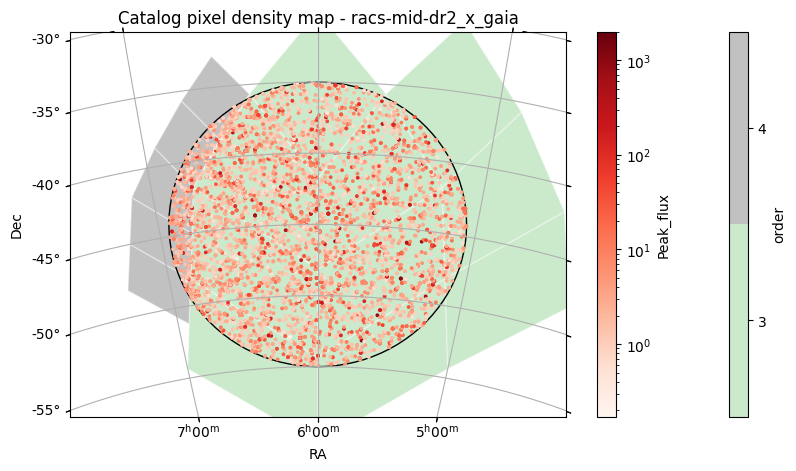

In [35]:
center = SkyCoord(90, -45, unit="deg")
radius_deg = 10.0

# Plot tile structure
fig, ax = cone_hats_catalog.plot_pixels(
    center=center,
    # Size of the viewbox, in RA and Dec.
    # We need to give it a bit more space to see the tiles.
    fov=(Angle(30.0, unit="deg"), Angle(30.0, unit="deg")),
    alpha=0.4,
    edgecolor="white",
    cmap='Accent',
)

# Plot the cone search region
circle_patch = SphericalCircle(
    center,
    Angle(radius_deg, unit="deg"),
    edgecolor="black",
    facecolor="none",
    transform=ax.get_transform("icrs"),
)
ax.add_patch(circle_patch)

# Plot the cross-matched sources
scatter = ax.scatter(
    df["RA"],
    df["Dec"],
    s=3,
    c=df["Peak_flux"],
    cmap="Reds",
    norm=LogNorm(),
    transform=ax.get_transform("icrs"),
)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Peak_flux")